## Análise sobre Transporte Urbano
### Autores:
 Orlando Junior

# 1. Preparação
Carregando os pacotes necessários e funções para formatar tabelas e gráficos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
from scipy.stats import kstest, shapiro


In [27]:
df_transporte = pd.read_csv('./data/Transporte_Urbano.csv')

# 1.1 Introdução

A mobilidade urbana é um dos pilares para o funcionamento eficiente de uma cidade, impactando diretamente a qualidade de vida de seus cidadãos.
Este projeto se dedica à análise de um conjunto de dados contendo 1100 registros de viagens urbanas, com o objetivo central de investigar e modelar a variável Tempo_viagem. Conforme o dicionário de dados, esta é a nossa variável dependente (alvo), representando a duração total de cada percurso em minutos.

O dataset é composto por 11 variáveis que caracterizam cada viagem, fornecendo uma visão multifacetada dos fatores que podem influenciar sua duração:

Métricas de Desempenho:

- Tempo_viagem (min): Duração total da viagem (variável alvo).

- Distancia_km: Distância percorrida.

- Velocidade_media_kmh: Velocidade média durante o trajeto.

- Tempo_espera (min): Tempo de espera associado à viagem.

- Condições de Tráfego e Rota:

- Congestionamento: Índice de 0 (livre) a 10 (parado).

- Hora_pico: Indica se a viagem ocorreu em horário de pico (Sim/Não).

- Ocorrencia_acidente: Aponta se houve acidente no percurso (Sim/Não).

- Paradas_intermediarias: Número de paradas realizadas.

- Fatores Externos e Modais:

- Tipo_transporte: Modal utilizado (Metrô, Ônibus, etc.).

- Chuva_mm: Intensidade da chuva em mm/h.

- Dia_semana: Dia da semana em que a viagem ocorreu.

Uma análise exploratória inicial revelou dois desafios críticos que precisam ser superados antes da modelagem. Primeiramente, foi detectada a presença de 11 valores ausentes em colunas-chave como Distancia_km, Velocidade_media_kmh e Chuva_mm. Em segundo lugar, a maioria das variáveis numéricas foi importada com o tipo object (texto), o que impede a realização de cálculos e análises estatísticas.

Dessa forma, a etapa inicial e crucial deste trabalho consistirá no pré-processamento dos dados. Isso envolverá a conversão dos tipos de dados para os formatos corretos (numérico e categórico) e a aplicação de uma estratégia robusta para tratar os valores ausentes, garantindo assim a qualidade e a integridade necessárias para as fases subsequentes de análise e construção de um modelo preditivo para o Tempo_viagem.

# 1.2 Identificação de campos vazios

In [6]:
df_transporte.isna().sum()

Tempo_viagem               0
Distancia_km              11
Velocidade_media_kmh      11
Congestionamento          11
Hora_pico                  0
Tipo_transporte            0
Paradas_intermediarias     0
Chuva_mm                  11
Dia_semana                 0
Ocorrencia_acidente        0
Tempo_espera              11
dtype: int64

Percebemos que existem 11 linhas nulas em algumas campos, vamos então realizar uma limpeza dessas linhas para que elas não atrapalhem na análise exploratória

In [8]:
df_transporte_EDA = df_transporte.copy()
df_transporte_EDA.dropna(inplace=True)


In [9]:
df_transporte_EDA.isna().sum()

Tempo_viagem              0
Distancia_km              0
Velocidade_media_kmh      0
Congestionamento          0
Hora_pico                 0
Tipo_transporte           0
Paradas_intermediarias    0
Chuva_mm                  0
Dia_semana                0
Ocorrencia_acidente       0
Tempo_espera              0
dtype: int64

Agora não temos mais as linhas nulas/vazias

In [11]:
df_transporte_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1047 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Tempo_viagem            1047 non-null   object
 1   Distancia_km            1047 non-null   object
 2   Velocidade_media_kmh    1047 non-null   object
 3   Congestionamento        1047 non-null   object
 4   Hora_pico               1047 non-null   object
 5   Tipo_transporte         1047 non-null   object
 6   Paradas_intermediarias  1047 non-null   int64 
 7   Chuva_mm                1047 non-null   object
 8   Dia_semana              1047 non-null   object
 9   Ocorrencia_acidente     1047 non-null   object
 10  Tempo_espera            1047 non-null   object
dtypes: int64(1), object(10)
memory usage: 98.2+ KB


# 2. Os Dados

In [15]:
df_transporte_EDA.head()

,Tempo_viagem,Distancia_km,Velocidade_media_kmh,Congestionamento,Hora_pico,Tipo_transporte,Paradas_intermediarias,Chuva_mm,Dia_semana,Ocorrencia_acidente,Tempo_espera
0,"10,98","0,95","35,38","3,16",Não,Ônibus,1,"2,27",Seg,Não,"9,79"
1,"50,1","6,31","25,66","5,11",Sim,Ônibus,3,0,Qua,Não,"15,03"
2,"41,5","4,75","33,08","3,51",Não,Ônibus,2,"2,5",Sex,Não,"12,71"
3,"37,18","1,56","22,95","5,79",Não,Bicicleta,1,"6,32",Ter,Não,"7,78"
4,"36,79","7,11","26,78","4,85",Não,Metrô,1,0,Ter,Não,"7,85"


In [25]:
# Função para ajustar os dados das colunas numéricas

def limpar_dados(df):
    df = df.copy()
    
    colunas_numericas = ['Tempo_viagem', 'Distancia_km', 'Velocidade_media_kmh', 
                        'Congestionamento', 'Chuva_mm', 'Tempo_espera']
    
    for coluna in colunas_numericas:
        if coluna in df.columns:
            if df[coluna].dtype == 'object':
                df[coluna] = df[coluna].str.replace(',', '.')
                df[coluna] = df[coluna].astype(float)
            elif df[coluna].dtype != 'float64':
                df[coluna] = df[coluna].astype(float)
    
    return df

df_transporte_EDA = limpar_dados(df_transporte_EDA)
df_transporte_EDA.info()
df_transporte_EDA.head()


<class 'pandas.core.frame.DataFrame'>
Index: 1047 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Tempo_viagem            1047 non-null   float64
 1   Distancia_km            1047 non-null   float64
 2   Velocidade_media_kmh    1047 non-null   float64
 3   Congestionamento        1047 non-null   float64
 4   Hora_pico               1047 non-null   object 
 5   Tipo_transporte         1047 non-null   object 
 6   Paradas_intermediarias  1047 non-null   int64  
 7   Chuva_mm                1047 non-null   float64
 8   Dia_semana              1047 non-null   object 
 9   Ocorrencia_acidente     1047 non-null   object 
 10  Tempo_espera            1047 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 98.2+ KB


,Tempo_viagem,Distancia_km,Velocidade_media_kmh,Congestionamento,Hora_pico,Tipo_transporte,Paradas_intermediarias,Chuva_mm,Dia_semana,Ocorrencia_acidente,Tempo_espera
0,10.98,0.95,35.38,3.16,Não,Ônibus,1,2.27,Seg,Não,9.79
1,50.10,6.31,25.66,5.11,Sim,Ônibus,3,0.00,Qua,Não,15.03
2,41.50,4.75,33.08,3.51,Não,Ônibus,2,2.50,Sex,Não,12.71
3,37.18,1.56,22.95,5.79,Não,Bicicleta,1,6.32,Ter,Não,7.78
4,36.79,7.11,26.78,4.85,Não,Metrô,1,0.00,Ter,Não,7.85


In [26]:
df_transporte_EDA.describe()

,Tempo_viagem,Distancia_km,Velocidade_media_kmh,Congestionamento,Paradas_intermediarias,Chuva_mm,Tempo_espera
count,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
mean,39.384575,7.195969,29.179436,4.152684,3.997135,1.735387,10.261127
std,19.295721,4.643676,7.041603,1.826287,2.777778,2.938683,4.174942
min,5.000000,-4.220000,8.000000,0.000000,0.000000,0.000000,-6.620000
25%,25.605000,3.885000,24.200000,2.865000,2.000000,0.000000,7.675000
50%,38.650000,6.200000,29.390000,4.070000,4.000000,0.000000,10.190000
75%,52.380000,9.465000,34.165000,5.390000,5.000000,2.710000,13.090000
max,111.380000,32.210000,46.960000,10.000000,17.000000,23.720000,21.090000


Após a importação e a identificação inicial dos problemas, a próxima etapa foi a limpeza e a preparação dos dados. Este processo garantiu que as colunas numéricas fossem tratadas corretamente e que o conjunto de dados estivesse livre de valores ausentes, permitindo a aplicação de funções estatísticas.

Após esse processo, o método .info() foi utilizado para verificar o resultado. Como podemos ver, o DataFrame agora possui 1047 entradas, e as colunas numéricas foram convertidas com sucesso para o tipo float64.

Com os dados limpos e devidamente tipados, o primeiro passo da análise exploratória foi gerar um resumo estatístico utilizando o método .describe():

- count: 1047 em todas as colunas, sem valores nulos.

- mean: A média de cada variável.

- std: O desvio padrão.

- min e max: Os valores mínimo e máximo.

- Quartis (25%, 50%, 75%): Valores que dividem os dados em quatro partes iguais.

Percebe-se alguns outliers, como o valor negativo para Distancia_km (-4.22) bem como em Tempo_espera (-6.62)

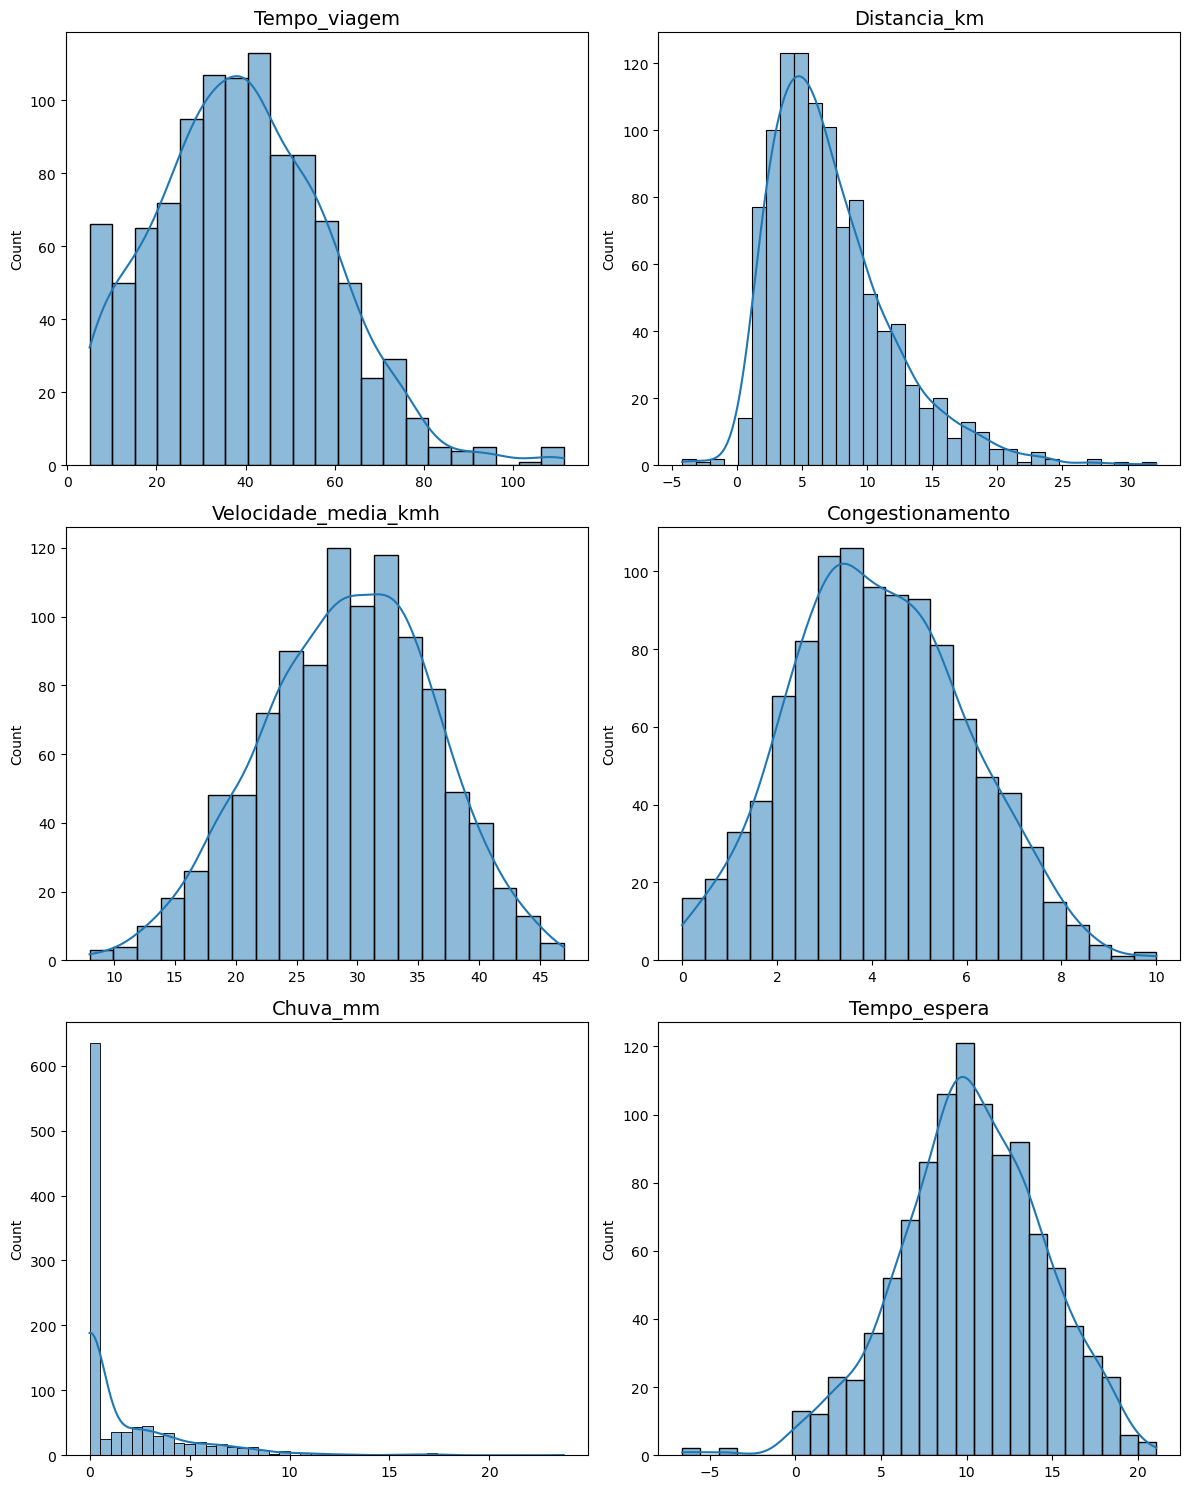

In [34]:

colunas_numericas = ['Tempo_viagem', 'Distancia_km', 'Velocidade_media_kmh', 
                     'Congestionamento', 'Chuva_mm', 'Tempo_espera']

fig, axes = plt.subplots(3, 2, figsize=(12, 15))

axes = axes.flatten()

for i, coluna in enumerate(colunas_numericas):
    sns.histplot(data=df_transporte_EDA, x=coluna, ax=axes[i], kde=True)
    axes[i].set_title(f'{coluna}', fontsize=14)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()